In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from scipy import stats

In [2]:
# create environment
class Discrete1DEnv:
    def __init__(self, nstates=5):
        self.states = np.arange(nstates) # number of discrete states. can be increased or decreased. Similar to taking discrete steps to the reward
        self.start_state = 1 # always start from state 1, such that the agent starts from the screen, after choice initiation
        self.reward_state = self.states[-2] # reward/terminal state is 1 before the final state.
        self.done = False # if done, trial ends and a new one begins
        self.maxt = 100 # max number of steps available for the agent to get to the reward state, afterwhich the trial ends and a new one begins.

    def reset(self): # start trial
        self.current_state = self.start_state # current state is the agent's current state
        self.done = False
        self.time = 0 # time = 0 for start
        return self.current_state

    def step(self, action=None):
      self.time+=1 # take a step in time

      # end trial if agent takes maxt steps and no reward
      if self.time >= self.maxt:
        self.done = True

      if action is None: # if no action specified, use optimal policy to move right
        if self.current_state < self.reward_state:
            self.current_state += 1
        else:
            self.done = True # end trial if agent reaches reward state
      else:
        if action == 0:
          self.current_state -= 1 # move back
        elif action == 1:
          self.current_state += 1 # move forward
        elif action == 2:
          self.current_state += 0 # stay
        else:
          raise ValueError("Invalid action. Must be 0, 1, or None.")

      # boundary conditions to prevent circular/unbounded environment
      if self.current_state < 0:
        self.current_state = 0
      elif self.current_state > len(self.states)-1:
        self.current_state = len(self.states)-1

      # reward contingency: no reward in other states
      if self.current_state == self.reward_state:
        reward = 1
        self.done = True # end trial if agent reaches reward state
      else:
        reward = 0

      return self.current_state, reward, self.done


In [3]:
# Agent implementation
class Agent:
    def __init__(self, gamma=0.95, eta=0.5, N=50, nstates=5, learn_policy=False, pf_type='simple', policy_prop=False, beta_alpha=0.0, sigma_init=0.5, weight_init=0.0):

        self.N = N # number of place cells

        # check out different critic weight initialization influences place cell shifts.
        # self.w = np.ones(self.N) * 0 # critic's weight for value estimation, all constants.

        # self.w = np.random.uniform(-1,1,self.N) * 1 # random uniform critic weights

        self.w = np.random.normal(size=self.N) * weight_init # random normal critic weights

        self.learn_policy = learn_policy # toggle True or False to learn a policy or use optimal policy
        self.pftype = pf_type # complexity of place cell with/without amplitude
        self.nact = 3 # move back,  forward, or stay
        self.W = np.zeros([self.nact, self.N]) # actor weight for policy learning
        self.lambdas = np.linspace(0, nstates-1, num=self.N) # initialized values for place field center of mass
        self.sigmas = np.ones(self.N) * sigma_init # initialized values for place field spread
        self.gamma0 = 1.0 # rich learning regime. keep to 1. originally 1/N for lazy regime
        # self.gamma0 = 1/self.N # weak learning regime
        self.gamma = gamma # TD error discount factor
        self.policy_prop = policy_prop

        # initialized values for place field amplitude
        if pf_type == 'alpha':
          self.alphas = np.ones(self.N) * 0
        else:
          self.alphas = np.ones(self.N) * 1.0
        self.beta_alpha = beta_alpha

        self.gamma0 = 1 # rich learning regime, 1/N for lazy learning
        # self.gamma0 = 1/self.N # weak learning regime
        self.eta = eta * self.gamma0**2 # learning rate
        self.trial_data = {
            'values': [],
            'td_errors': [],
            'lambdas': [],
            'states':[],
            'latencies':[],
            'sigmas':[],
            'alphas':[]
        }

        if pf_type == 'simple':
          self.phi = self.phi_simple
        elif pf_type == 'alpha':
          self.phi = self.phi_alpha
        elif pf_type == 'norm':
          self.phi = self.phi_norm

    def phi_simple(self, s): # simple place cell model with constant amplitude = 1 and variable center
        return np.exp(-(s - self.lambdas)**2 / (2 * self.sigmas**2))

    def phi_alpha(self, s): # place cell with variable amplitdue and center
        return self.sigmoid(self.alphas) * np.exp(-(s - self.lambdas)**2 / (2 * self.sigmas**2))

    # def phi_alpha(self, s):
    #     return self.alphas**2 * np.exp(-(s - self.lambdas)**2 / (2 * self.sigmas**2))

    def phi_norm(self, s):
        # return (1 / (self.sigmoid(self.sigmas) * np.sqrt(2*np.pi))) * np.exp(-(s - self.lambdas)**2 / (2 * self.sigmoid(self.sigmas)**2))
        return (1 / (self.sigmas * np.sqrt(2*np.pi))) * np.exp(-(s - self.lambdas)**2 / (2 * self.sigmas**2))

    def value(self, s):# place cell with normalized amplitude
        return 1/(self.gamma0*self.N) * np.sum(self.w * self.phi(s))

    def sigmoid(self,x):
        return 1/(1+np.exp(-x))

    def get_action(self,s):
        a_t = 1/(self.gamma0*self.N) * np.sum(self.W * self.phi(s),axis=1)
        P_t = np.exp(a_t) / np.sum(np.exp(a_t))
        action = np.random.choice(self.nact, p=P_t)
        g_t = np.zeros(self.nact)
        g_t[action] = 1
        self.gtilde = g_t - P_t
        return action

    def run_trial(self, env):
        state = env.reset()
        done = False
        trial_values = []
        trial_td_errors = []
        states = []

        while not done:

            if self.learn_policy:
              action = self.get_action(state)
            else:
              action = None

            next_state, reward, done = env.step(action)

            # compute TD error
            v_s = self.value(state)
            v_next = self.value(next_state) if not done else 0
            td_error = reward + self.gamma * v_next - v_s

            # compute gradients
            phi_s = self.phi(state)

            # Update critic weights
            # dw = delta_t * phi_t
            delta_w = td_error * phi_s
            self.w += self.eta * delta_w /(self.gamma0*self.N)

            # add constraint on w to be positive semi-definite
            self.w = np.maximum(self.w, 0)

            if self.learn_policy:
              # update actor weights
              # dW = (g-P) @ phi_t * delta_t
              delta_W = self.gtilde[:,None] @ phi_s[None,:] * td_error
              self.W += self.eta * delta_W /(self.gamma0*self.N)

            # Update lambdas using only critic weights
            delta_lambda = td_error * self.w * phi_s * (state - self.lambdas) / self.sigmas
            if self.policy_prop:
              # Update lambdas using both actor & critic weights
              delta_lambda = td_error * (self.w + self.gtilde @ self.W) * phi_s * (state - self.lambdas) / self.sigmas
            self.lambdas += self.eta * delta_lambda /(self.gamma0*self.N)

            # update alphas
            if self.pftype == 'alpha':
              # delta_alpha = td_error * self.w * phi_s * (2/self.alphas)
              delta_alpha = td_error * self.w * phi_s * (1-self.sigmoid(self.alphas)) - self.beta_alpha * self.alphas
              # delta_alpha = td_error * self.w * phi_s * (2/self.alphas) - self.beta_alpha * self.alphas
              if self.policy_prop:
                  delta_alpha = td_error * (self.w + self.gtilde @ self.W) * phi_s * (1-self.sigmoid(self.alphas)) - self.beta_alpha * self.alphas
                  # delta_alpha = td_error * (self.w + self.gtilde @ self.W) * phi_s * (2/self.alphas) - self.beta_alpha * self.alphas
              self.alphas += self.eta * delta_alpha /(self.gamma0*self.N)

            # update sigmas
            # if self.pftype == 'sigma':
            #   delta_sigma = td_error * self.w * phi_s * (state - self.lambdas)**2 / self.sigmas**3
            #   self.sigmas += self.eta * delta_sigma

            # update norm
            if self.pftype == 'norm':
              delta_sigma = td_error * self.w * phi_s * (((state - self.lambdas)**2 / self.sigmas**3) - (1/self.sigmas))
              # delta_sigma = td_error * self.w * phi_s * ((((state - self.lambdas)**2 / self.sigmoid(self.sigmas)**2) -1) * self.sigmoid(self.sigmas)*(1-self.sigmoid(self.sigmas)))
              if self.policy_prop:
                delta_sigma = td_error * (self.w + self.gtilde @ self.W) * phi_s * (((state - self.lambdas)**2 / self.sigmas**3) - (1/self.sigmas))
                # delta_sigma = td_error * (self.w + self.gtilde @ self.W) * phi_s * ((((state - self.lambdas)**2 / self.sigmoid(self.sigmas)**2) -1) * self.sigmoid(self.sigmas)*(1-self.sigmoid(self.sigmas))  )
              self.sigmas += self.eta * delta_sigma /(self.gamma0*self.N)


            trial_values.append(v_s)
            trial_td_errors.append(td_error)
            states.append(state)
            state = next_state

        self.trial_data['values'].append(trial_values)
        self.trial_data['td_errors'].append(trial_td_errors)
        self.trial_data['lambdas'].append(self.lambdas.copy())
        self.trial_data['sigmas'].append(self.sigmas.copy())
        self.trial_data['alphas'].append(self.alphas.copy())
        self.trial_data['states'].append(states)
        self.trial_data['latencies'].append(env.time)

In [4]:
# Simulation
# agent params


learn_policy = False # If True, agent will learn a policy for noisier field updates. If False, agent uses optimal policy and we see smoother backward shifts
pf_type = 'simple' # 'simple', 'alpha', 'norm'
policy_prop = False # If True, update place cell parameters using policy weights too
beta_alpha = 0.0
weight_init = 0.0

N = 1000
eta0 = 0.1
sigma_scale = 0.5
gamma= 0.95

eta = eta0 * N

# assert that if policy_prop is True, learn_policy must be True
if policy_prop:
    assert learn_policy, "If policy_prop is True, learn_policy must be True"

# env params
num_trials = 1000
nstates = 10

env = Discrete1DEnv(nstates)
agent = Agent(gamma, eta,N, nstates,learn_policy, pf_type, policy_prop, beta_alpha, sigma_scale, weight_init)

for t in range(num_trials):
    agent.run_trial(env)

    # add noise after N trials
    if (t+1)%20 == 0:
        agent.lambdas += np.random.normal(size=N) * 0.0

# Prepare data for plotting
states = env.states
trials = range(1, num_trials + 1)

# Create 3D arrays for values and TD errors (trials × states)
value_matrix = np.zeros((num_trials, len(states)))
td_matrix = np.zeros((num_trials, len(states)))

for trial in range(num_trials):
    for i, state in enumerate(agent.trial_data['states'][trial]):
        value_matrix[trial, state] = agent.trial_data['values'][trial][i]
        td_matrix[trial, state] = agent.trial_data['td_errors'][trial][i]

# Lambda values for each trial
sigmas = np.array(agent.trial_data['sigmas'])
lambdas = np.array(agent.trial_data['lambdas'])
alphas = np.array(agent.trial_data['alphas'])



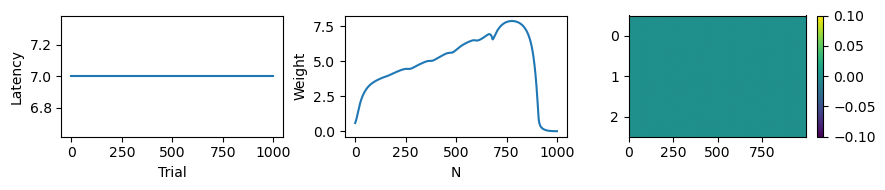

In [5]:
plt.figure(figsize=(9,2))
plt.subplot(131)
plt.plot(agent.trial_data['latencies'])
plt.ylabel('Latency')
plt.xlabel('Trial')
plt.subplot(132)
plt.plot(agent.w)
plt.ylabel('Weight')
plt.xlabel('N')
plt.subplot(133)
plt.imshow(agent.W,aspect='auto')
plt.colorbar()
plt.tight_layout()

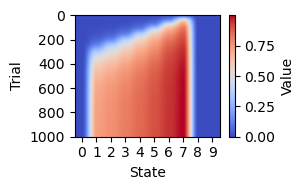

In [6]:
# Define yticks to use for all plots
yticks = np.linspace(0, num_trials, 6, dtype=int)

# Figure 1: Value function plot
plt.figure(figsize=(3, 2))
im1 = plt.imshow(value_matrix, aspect='auto', cmap='coolwarm', origin='upper')
plt.colorbar(im1, label='Value')
# plt.title('State Value Estimates')
plt.xlabel('State')
plt.ylabel('Trial')
plt.xticks(range(len(states)), states)
plt.yticks(yticks)
plt.gca().set_yticklabels(yticks)
plt.tight_layout()
# plt.savefig(f'./figs/value_state_trial_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')

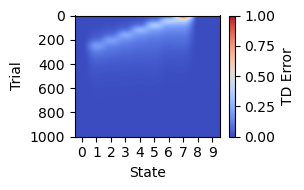

In [7]:
# Figure 2: TD error plot
plt.figure(figsize=(3, 2))
im2 = plt.imshow(td_matrix, aspect='auto', cmap='coolwarm', origin='upper')
plt.colorbar(im2, label='TD Error')
# plt.title('Temporal Difference Errors')
plt.xlabel('State')
plt.ylabel('Trial')
plt.xticks(range(len(states)), states)
plt.yticks(yticks)
plt.gca().set_yticklabels(yticks)
plt.tight_layout()
# plt.savefig(f'./figs/td_state_trial_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')

In [8]:
np.sum(td_matrix[-1])/nstates # difference in TD error from first to last trial

0.0001383054970485853

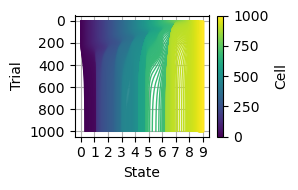

In [9]:
# Figure 3: Lambda values plot
plt.figure(figsize=(3, 2))
cmap = cm.viridis
for i in range(agent.N):
    color = cmap(i / (N-1))
    plt.plot(lambdas[:, i], trials, color=color, linewidth=1)
# plt.title('Lambda Parameter Evolution')
plt.xlabel('State')
plt.ylabel('Trial')
plt.xticks(range(len(states)), states)
plt.yticks(yticks)
plt.grid(True)
plt.gca().invert_yaxis()  # This ensures y increases downward
norm = Normalize(vmin=0, vmax=N)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Cell')
plt.tight_layout()
# plt.savefig(f'./figs/lambda_state_trial_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')

In [10]:
env.start_state+0.5

1.5

In [11]:
# Figure 4: Average COM shift plot
# reward cells

rp_idx1 = lambdas[0] < env.reward_state+0.5
rp_idx2 = lambdas[0] >= env.reward_state-0.5
rp_idx = rp_idx1 * rp_idx2
rp = np.arange(N)[rp_idx]
drp = lambdas[-1][rp] - lambdas[0][rp]
dalpha_rp = alphas[-1][rp] - alphas[0][rp]

#reward approach cells
ra_idx1 = lambdas[0] < env.reward_state-0.5
ra_idx2 = lambdas[0] >= env.reward_state-6.5
ra_idx = ra_idx1 * ra_idx2
ra = np.arange(N)[ra_idx]
dra = lambdas[-1][ra] - lambdas[0][ra]
dalpha_ra = alphas[-1][ra] - alphas[0][ra]

# screen/start cells
sc_idx1 = lambdas[0] < env.start_state+0.5
sc_idx2 = lambdas[0] >= env.start_state-0.5
sc_idx = sc_idx1 * sc_idx2
sc = np.arange(N)[sc_idx]
dsc = lambdas[-1][sc] - lambdas[0][sc]
dalpha_sc = alphas[-1][sc] - alphas[0][sc]

all_lambda = lambdas[-1] - lambdas[0]
all_alpha = alphas[-1] - alphas[0]



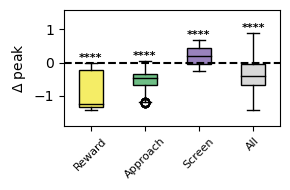

In [12]:
plt.figure(figsize=(3, 2))
data = [drp, dra, dsc, all_lambda]
labels = ['Reward', 'Approach', 'Screen', 'All']

# Define colors with transparency (alpha=0.5)
colors = [
    (0.945, 0.902, 0.145, 0.7),  # Yellow (Viridis endpoint)
    (0.188, 0.639, 0.322, 0.7),  # Green (Viridis midpoint)
    (0.436, 0.308, 0.631, 0.7),  # Purple (Viridis startpoint)
    (0.7, 0.7, 0.7, 0.5)          # Grey for 'All'
]


box = plt.boxplot(data, labels=labels, patch_artist=True,
                 showmeans=False, showfliers=True)

# Apply colors to each boxplot
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor((0, 0, 0, 1))  # Black edges

# Customize other boxplot elements
for element in ['whiskers', 'caps', 'medians']:
    plt.setp(box[element], color='black')

plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('$\Delta$ peak')

# Perform statistical tests against μ=0 and add significance markers
for i, (dataset, label) in enumerate(zip(data, labels)):
    t_stat, p_val = stats.ttest_1samp(dataset, popmean=0)
    if p_val < 0.0001:
        sig_symbol = '****'
    elif p_val < 0.001:
        sig_symbol = '***'
    elif p_val < 0.01:
        sig_symbol = '**'
    elif p_val < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'ns'

    # Position the significance marker above the boxplot
    y_pos = np.percentile(dataset, 99)+0.005 #+ 0.2 * np.ptp(np.concatenate(data))
    plt.text(i+1, y_pos,
             sig_symbol,
             ha='center', va='bottom',
             fontsize=8,
             fontweight='bold')

# Set y-axis limits with some padding
plt.ylim(bottom=min(0, min(np.concatenate(data)) - 0.2*np.ptp(np.concatenate(data))),
         top=max(np.concatenate(data)) + 0.3*np.ptp(np.concatenate(data)))  # Increased top padding for markers

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
# plt.savefig(f'./figs/rp_ra_s_barplot_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')
# plt.savefig(f'./figs/rp_ra_s_barplot_policy{learn_policy}.png', dpi=300, bbox_inches='tight')

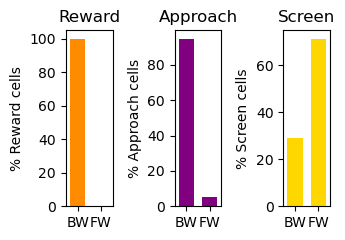

In [13]:
colors = ['darkorange', 'purple','gold']
f, ax = plt.subplots(1, 3, figsize=(3.5, 2.5))
for i in range(3):
    d = data[i]
    label = labels[i]
    bw = 100 * np.sum(d < 0) / len(d)  # backward shift
    fw = 100 * np.sum(d > 0) / len(d)  # forward shift
    ax[i].bar(['BW', 'FW'], [bw, fw], color=colors[i], width=0.65)
    ax[i].set_ylabel(f'% {label} cells')
    ax[i].set_title(f'{label}')
    ax[i].set_xlim(-0.5, 1.5)  # Add white space on both sides
f.tight_layout()

/var/folders/9w/2t7dk80j0vncsnz93dbrg1080000gp/T/ipykernel_1013/414865141.py:52: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(bottom=min(0, min(np.concatenate(data)) - 0.2*np.ptp(np.concatenate(data))),
/var/folders/9w/2t7dk80j0vncsnz93dbrg1080000gp/T/ipykernel_1013/414865141.py:56: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


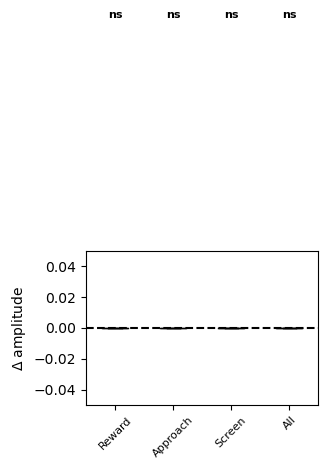

In [14]:
plt.figure(figsize=(3, 2))
data = [dalpha_rp, dalpha_ra, dalpha_sc, all_alpha]
labels = ['Reward', 'Approach', 'Screen', 'All']

# Define colors with transparency (alpha=0.5)
colors = [
    (0.945, 0.902, 0.145, 0.7),  # Yellow (Viridis endpoint)
    (0.188, 0.639, 0.322, 0.7),  # Green (Viridis midpoint)
    (0.436, 0.308, 0.631, 0.7),  # Purple (Viridis startpoint)
    (0.7, 0.7, 0.7, 0.5)          # Grey for 'All'
]


box = plt.boxplot(data, labels=labels, patch_artist=True,
                 showmeans=False, showfliers=True)

# Apply colors to each boxplot
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor((0, 0, 0, 1))  # Black edges

# Customize other boxplot elements
for element in ['whiskers', 'caps', 'medians']:
    plt.setp(box[element], color='black')

plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('$\Delta$ amplitude')

# Perform statistical tests against μ=0 and add significance markers
for i, (dataset, label) in enumerate(zip(data, labels)):
    t_stat, p_val = stats.ttest_1samp(dataset, popmean=0)
    if p_val < 0.0001:
        sig_symbol = '****'
    elif p_val < 0.001:
        sig_symbol = '***'
    elif p_val < 0.01:
        sig_symbol = '**'
    elif p_val < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'ns'

    # Position the significance marker above the boxplot
    y_pos = np.percentile(dataset, 99)+0.2 #+ 0.2 * np.ptp(np.concatenate(data))
    plt.text(i+1, y_pos,
             sig_symbol,
             ha='center', va='bottom',
             fontsize=8,
             fontweight='bold')

# Set y-axis limits with some padding
plt.ylim(bottom=min(0, min(np.concatenate(data)) - 0.2*np.ptp(np.concatenate(data))),
         top=max(np.concatenate(data)) + 0.3*np.ptp(np.concatenate(data)))  # Increased top padding for markers

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
# plt.savefig(f'./figs/alpha_rp_ra_s_barplot_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')
# plt.savefig(f'./figs/rp_ra_s_barplot_policy{learn_policy}.png', dpi=300, bbox_inches='tight')

-1.4357890724005493 0.8867346914863855


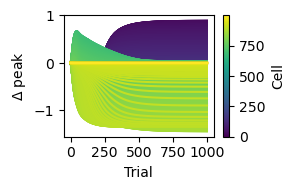

In [15]:
# Figure 5: Individual COM changes plot
plt.figure(figsize=(3, 2))
dlambdas = lambdas - lambdas[0]
for i in range(N):
    color = cmap(i / (N-1))
    plt.plot(np.arange(num_trials), dlambdas[:, i], color=color, zorder=1)

norm = Normalize(vmin=0, vmax=N-1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Cell')
plt.ylabel('$\Delta$ peak')
plt.xlabel('Trial')
xticks = np.linspace(0, num_trials, 5, dtype=int)
plt.xticks(xticks, xticks)
plt.gca().set_xticklabels(xticks)
plt.tight_layout()
# plt.savefig(f'./figs/delta_lambda_trial_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')
# plt.savefig(f'./figs/delta_lambda_trial_policy{learn_policy}.png', dpi=300, bbox_inches='tight')

print(dlambdas.min(), dlambdas.max())

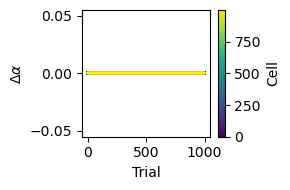

In [16]:
# Figure 5: Individual alpha changes plot
cmap = cm.viridis
plt.figure(figsize=(3, 2))
dalphas = alphas - alphas[0]
for i in range(N):
    color = cmap(i / (N-1))
    plt.plot(np.arange(num_trials), dalphas[:, i], color=color, zorder=1)

norm = Normalize(vmin=0, vmax=N-1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Cell')
plt.ylabel('$\Delta \\alpha$')
plt.xlabel('Trial')
plt.tight_layout()
# plt.savefig(f'./figs/delta_alpha_trial_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')
# plt.savefig(f'./figs/delta_alpha_trial_policy{learn_policy}.png', dpi=300, bbox_inches='tight')

(55,)


/var/folders/9w/2t7dk80j0vncsnz93dbrg1080000gp/T/ipykernel_1013/2229558456.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


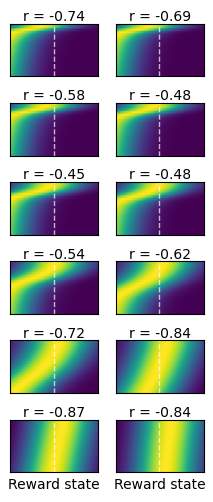

In [17]:
# Figure 6: The 10 small subplots in one figure
if learn_policy:
    plt.figure(figsize=(2.5, 12))
else:
    plt.figure(figsize=(2.5, 12))
inner_grid = gridspec.GridSpec(12, 2, wspace=0.2, hspace=0.5)

downsample = 10
maxtrials = 200
idx1 = lambdas[0] < env.reward_state+0.25
idx2 = lambdas[0] > env.reward_state-0.25
idx = idx1 * idx2
rp = np.arange(N)[idx]
print(rp.shape)
idx12 = np.linspace(0, len(rp)-1, 12, dtype=int)
rp = rp[idx12]

xs = np.linspace(7,9,100)
def get_phi(rpi):
    return np.exp(-(xs[None,:] - lambdas[:,rpi][:,None])**2 / (2 * sigmas[:,rpi][:,None]**2))

rxs = np.argmin(abs(xs-env.reward_state))

for i in range(12):
    ax = plt.subplot(inner_grid[i])

    ax.imshow(get_phi(rp[i])[:maxtrials][::downsample], aspect='auto', cmap='viridis', origin='upper')

    # ax.imshow(phis[rp[i]][::downsample][:,5:9], aspect='auto', cmap='viridis', origin='upper')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axvline(x=rxs, color='white', linestyle='--', linewidth=1, alpha=0.7)
    # ax.axvline(x=env.start_state, color='green', linestyle='--', linewidth=1, alpha=0.7)

    slope, intercept, r_value, p_value, std_err = stats.linregress(trials, lambdas[:,rp[i]])
    # ax.set_ylabel(f'PF {rp[i]}', fontsize=8)
    ax.set_title(f'r = {r_value:.2f}',fontsize=10, pad=-0.1)
    # if i % 2 == 0:
    #     ax.set_ylabel('Trial', fontsize=8)
    if i >= 10:
        ax.set_xlabel('Reward state',fontsize=10)
        # ax.set_xticks([env.start_state, env.reward_state])
        # ax.set_xticklabels(['Start', 'Reward'])

# plt.suptitle('Place Field Activity for Selected Cells', y=1.02)
plt.tight_layout()
# plt.savefig(f'./figs/example_lambda_session_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')
# plt.savefig(f'./figs/example_lambda_session_policy{learn_policy}.png', dpi=300, bbox_inches='tight')

166
[  0  15  30  45  60  75  90 105 120 135 150 165 180 195]


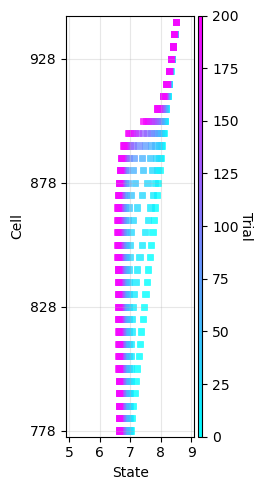

In [18]:
# Identify cells that shifted backward near reward location
backward_threshold = -0.0
back_shift_idx = (lambdas[-1] - lambdas[0]) < backward_threshold
reward_region_idx = (lambdas[0] > env.reward_state-1) & (lambdas[0] < env.reward_state+0.5)
back_shift_cells = np.arange(N)[back_shift_idx & reward_region_idx]
print(len(back_shift_cells))


back_shift_cells = back_shift_cells[::5]

# samp_trials = 500
samp_trials = 200
total_sessions = 15
# Create figure with appropriate dimensions
if learn_policy:
    plt.figure(figsize=(2.75, 5))
else:
    plt.figure(figsize=(2.75, 5))

# Create cool colormap for trials
cmap = plt.cm.cool
norm = plt.Normalize(vmin=0, vmax=samp_trials)

# Sample every 10th trial (adjust as needed)
sampled_trials = np.arange(0, samp_trials, total_sessions, dtype=int)
print(sampled_trials)

# Preallocate data for scatter plot
all_x = []
all_y = []
all_colors = []

# Collect data for plotting (vectorized approach)
for i, n in enumerate(back_shift_cells):  # Only first 10 cells as in your example
    cell_lambdas = lambdas[sampled_trials, n]
    all_x.extend(cell_lambdas)
    all_y.extend([i] * len(sampled_trials))
    all_colors.extend(cmap(norm(sampled_trials)))

# Single scatter plot call (much faster)
plt.scatter(all_x, all_y, c=all_colors, alpha=0.8, s=20, linewidths=0.5, marker='s')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02, aspect=100, fraction=0.3)
cbar.set_label('Trial', rotation=270, labelpad=10, fontsize=10)

# Formatting
plt.xlabel('State', fontsize=10)
plt.ylabel('Cell', fontsize=10)
plt.yticks(range(len(back_shift_cells))[::10], back_shift_cells[::10])  # Only show indices for plotted cells
plt.xlim([4.9,9.1])
plt.ylim([-0.5, len(back_shift_cells)-0.5])
plt.xticks(np.arange(5,10),np.arange(5,10))
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig(f'./figs/lambda_evolution_cool_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')

In [19]:
# backward shifting pf cause incorrect trials?
if learn_policy:
    correct_trials_idx = np.diff(np.array(agent.trial_data['latencies']))<0
    incorrect_trials_idx = np.diff(np.array(agent.trial_data['latencies']))>0

    idx1 = lambdas[0]<8.5
    idx2 = lambdas[0]>3
    idx = idx1 * idx2
    # idx = rp_idx

    # lambdas = np.array(agent.trial_data['lambdas'])
    # rp_idx1 = lambdas[0] < env.reward_state+0.25
    # rp_idx2 = lambdas[0] > env.reward_state-0.75
    # idx = rp_idx1 * rp_idx2


    print(correct_trials_idx.shape)

    correct_lambdas = []
    for i in np.arange(1, num_trials)[correct_trials_idx]:  # choose correct trials
        correct_lambdas.append((lambdas[i]-lambdas[i-1])[idx]) # filter out reward cells, see difference

    incorrect_lambdas = []
    for i in np.arange(1, num_trials)[incorrect_trials_idx]:
        incorrect_lambdas.append((lambdas[i]-lambdas[i-1])[idx])

    all_lambdas = []
    for i in np.arange(1, num_trials):
        all_lambdas.append((lambdas[i]-lambdas[i-1])[idx])

    incorrect_lambdas = np.array(incorrect_lambdas)
    correct_lambdas = np.array(correct_lambdas)
    all_lambdas = np.array(all_lambdas)


    print(correct_lambdas.shape)
    print(incorrect_lambdas.shape)


    print(np.mean(correct_lambdas))
    print(np.mean(incorrect_lambdas))
    print(np.mean(all_lambdas))

In [20]:
if learn_policy:
    plt.figure(figsize=(3,2))
    plt.plot(agent.trial_data['latencies'], linewidth=1, color='gray')
    plt.ylabel('Latency')
    plt.xlabel('Trial')
    plt.tight_layout()
    # plt.savefig(f'./figs/latency_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')
    # plt.savefig(f'./figs/latency_policy{learn_policy}.png', dpi=300, bbox_inches='tight')

In [21]:
if learn_policy:
    plt.figure(figsize=(3, 2), facecolor='white')

    data = [np.mean(all_lambdas,axis=1), np.mean(incorrect_lambdas,axis=1), np.mean(correct_lambdas,axis=1)]
    # Calculate statistics
    means = [np.mean(d) for d in data]
    sems = [stats.sem(d) for d in data]

    labels = ['Consecutive', 'Decreased', 'Increased']
    x_pos = np.arange(len(labels))
    outlier_colors = ['green', 'blue', 'orange']

    # Create bars with error bars
    bars = plt.bar(labels, means, width=0.6,
                color=[0.7, 0.7, 0.7, 0.7],
                edgecolor='black',
                linewidth=1,
                yerr=sems,
                capsize=5)
    # plt.errorbar(labels, means, yerr=sems, fmt='o', capsize=5)

    # # Add mean lines on top of bars
    # for i, mean in enumerate(means):
    #     plt.plot([x_pos[i]-0.3, x_pos[i]+0.3], [mean, mean],
    #              color='black', linewidth=2)

    # Add outliers with original colors
    for i, d in enumerate(data):
        # Jitter x-position for visibility
        x_jittered = np.random.normal(x_pos[i], 0.00, size=len(d))
        plt.scatter(x_jittered, d,
                    color=outlier_colors[i],
                    alpha=0.2,
                    edgecolors=outlier_colors[i],
                    s=20)

    plt.ylabel('Peak shift')
    plt.xticks(x_pos, labels, fontsize=8)
    plt.axhline(y=0, color='black')

    # Keep your original significance testing code
    comparisons = [(0, 1), (0, 2), (1, 2)]
    y_max = max([np.max(d) for d in data])  # Find maximum y-value
    bar_levels = [y_max * 1.1, y_max * 1.2, y_max * 1.3]

    for (i, j), level in zip(comparisons, bar_levels):
        t_stat, p_val = stats.ttest_ind(data[i], data[j])
        if p_val < 0.05:
            symbol = '*' * min(4, int(-np.log10(p_val)) + 1)
            plt.plot([x_pos[i], x_pos[j]], [level, level], color='black')
            plt.text((x_pos[i]+x_pos[j])/2, level, symbol,
                    ha='center', va='bottom', fontsize=10)

    plt.ylim(top=y_max * 1.6)
    plt.tight_layout()
    # plt.savefig(f'./figs/correct_incorrect_backshift_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')
    # plt.savefig(f'./figs/correct_incorrect_backshift_policy{learn_policy}.png', dpi=300, bbox_inches='tight')

In [22]:
# plot change in firing rate at reward, screen locations.
xs = np.linspace(0,9,101)

def get_phi(tidx):
    return np.exp(-(xs[None,:] - lambdas[tidx][:,None])**2 / (2 * sigmas[tidx][:,None]**2))

pre_phis = get_phi(0)
middle_phis = get_phi(int(200))
post_phis = get_phi(int(num_trials-1))

pre_phis = np.mean(pre_phis,axis=0)
middle_phis = np.mean(middle_phis,axis=0)
post_phis = np.mean(post_phis,axis=0)

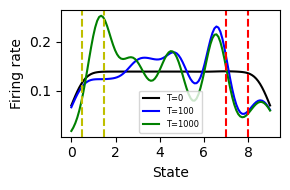

In [23]:
plt.figure(figsize=(3, 2))
plt.plot(xs, pre_phis,color='k', label='T=0')
plt.plot(xs, middle_phis,color='b', label='T=100')
plt.plot(xs, post_phis,color='g', label=f'T={num_trials}')
plt.xlabel('State')
plt.ylabel('Firing rate')
plt.legend(fontsize=6)
plt.axvline(8,color='r',linestyle='--')
plt.axvline(7,color='r',linestyle='--')
plt.axvline(0.5,color='y',linestyle='--')
plt.axvline(1.5,color='y',linestyle='--')
plt.tight_layout()

In [24]:
# plot change in firing rate at reward, screen locations.
xs = np.linspace(0,9,101)

def get_phi(tidx):
    return np.exp(-(xs[None,:] - lambdas[tidx][:,None])**2 / (2 * sigmas[tidx][:,None]**2))

all_phis = []
for i in range(0, num_trials, 10):
  all_phis.append(np.mean(get_phi(int(i)),axis=0))

final_array = np.vstack(all_phis)

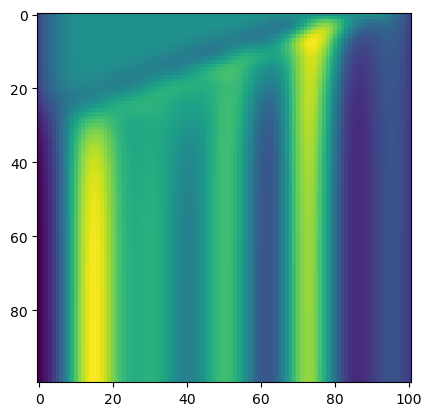

In [25]:
plt.figure()
plt.imshow(final_array)
plt.show()

In [26]:
# Figure 4: Average COM shift plot
# reward cells

rp_idx1 = xs < env.reward_state+0.5
rp_idx2 = xs > env.reward_state-0.5
rp_idx = rp_idx1 * rp_idx2
drp = post_phis[rp_idx] - pre_phis[rp_idx]

#reward approach cells
ra_idx1 = xs < env.reward_state-0.5
ra_idx2 = xs > env.reward_state-6.5
ra_idx = ra_idx1 * ra_idx2
dra = post_phis[ra_idx] - pre_phis[ra_idx]

# screen/start cells
sc_idx1 = xs < env.start_state+0.5
sc_idx2 = xs > env.start_state-0.5
sc_idx = sc_idx1 * sc_idx2
dsc = post_phis[sc_idx] - pre_phis[sc_idx]

all_phis = post_phis - pre_phis

print(drp.shape)


(11,)


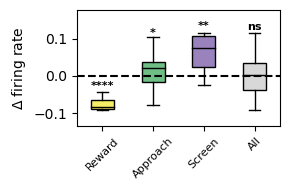

In [27]:
plt.figure(figsize=(3, 2))
data = [drp, dra, dsc, all_phis]
labels = ['Reward', 'Approach', 'Screen', 'All']

# Define colors with transparency (alpha=0.5)
colors = [
    (0.945, 0.902, 0.145, 0.7),  # Yellow (Viridis endpoint)
    (0.188, 0.639, 0.322, 0.7),  # Green (Viridis midpoint)
    (0.436, 0.308, 0.631, 0.7),  # Purple (Viridis startpoint)
    (0.7, 0.7, 0.7, 0.5)          # Grey for 'All'
]


box = plt.boxplot(data, labels=labels, patch_artist=True,
                 showmeans=False, showfliers=True)

# Apply colors to each boxplot
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor((0, 0, 0, 1))  # Black edges

# Customize other boxplot elements
for element in ['whiskers', 'caps', 'medians']:
    plt.setp(box[element], color='black')

plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('$\Delta$ firing rate')

# Perform statistical tests against μ=0 and add significance markers
for i, (dataset, label) in enumerate(zip(data, labels)):
    t_stat, p_val = stats.ttest_1samp(dataset, popmean=0)
    if p_val < 0.0001:
        sig_symbol = '****'
    elif p_val < 0.001:
        sig_symbol = '***'
    elif p_val < 0.01:
        sig_symbol = '**'
    elif p_val < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'ns'

    # Position the significance marker above the boxplot
    y_pos = np.percentile(dataset, 99)+0.005 #+ 0.2 * np.ptp(np.concatenate(data))
    plt.text(i+1, y_pos,
             sig_symbol,
             ha='center', va='bottom',
             fontsize=8,
             fontweight='bold')

# Set y-axis limits with some padding
plt.ylim(bottom=min(0, min(np.concatenate(data)) - 0.2*np.ptp(np.concatenate(data))),
         top=max(np.concatenate(data)) + 0.3*np.ptp(np.concatenate(data)))  # Increased top padding for markers

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
# plt.savefig(f'./figs/rp_ra_s_barplot_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')
# plt.savefig(f'./figs/rp_ra_s_barplot_policy{learn_policy}.png', dpi=300, bbox_inches='tight')

In [28]:
agent.w.min()

0.002368448960077765

In [29]:
# Percentage of cells across time.

perc_reward_cells = []
perc_reward_approach_cells = []
perc_screen_cells = []

for i in range(num_trials):
  rp_idx1 = lambdas[i] < env.reward_state+0.5
  rp_idx2 = lambdas[i] > env.reward_state-0.5
  rp_idx = rp_idx1 * rp_idx2
  perc_reward_cells.append(int(np.sum(rp_idx)))

  rp_idx1 = lambdas[i] < env.reward_state-3
  rp_idx2 = lambdas[i] > env.reward_state-4
  rp_idx = rp_idx1 * rp_idx2
  perc_reward_approach_cells.append(int(np.sum(rp_idx)))

  sc_idx1 = lambdas[i] < env.start_state+0.5
  sc_idx2 = lambdas[i] > env.start_state-0.5
  sc_idx  = sc_idx1 * sc_idx2
  perc_screen_cells.append(int(np.sum(sc_idx)))


perc_reward_cells = 100*np.array(perc_reward_cells)/num_trials
perc_reward_approach_cells = 100*np.array(perc_reward_approach_cells)/num_trials
perc_screen_cells = 100*np.array(perc_screen_cells)/num_trials

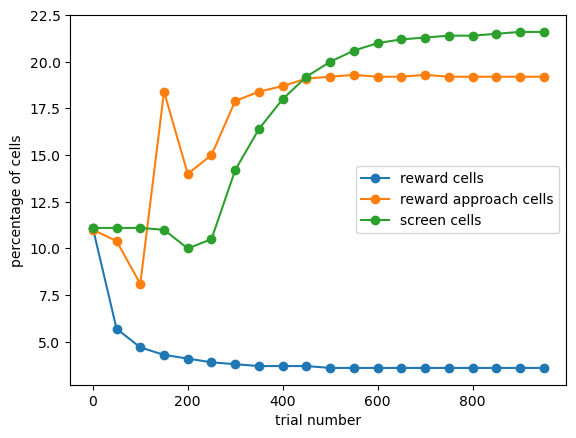

In [30]:
indices = np.arange(0, num_trials, 50)
plt.figure()
plt.plot(indices, perc_reward_cells[indices], marker = 'o',  label='reward cells')
plt.plot(indices, perc_reward_approach_cells[indices], marker = 'o', label='reward approach cells')
plt.plot(indices, perc_screen_cells[indices], marker = 'o', label='screen cells')
plt.xlabel('trial number')
plt.ylabel('percentage of cells')
plt.legend(fontsize=10)
plt.show()